要构建Transformer模型，需要以下步骤：
- 导入库和模块
- 定义基本构建块-多头注意力、前馈神经网络、位置编码
- 构建编码器层
- 构建解码器层
- 结合编码器层和解码器层等，创建完整的Transformer网络

## 1.导入库和模块

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

## 2.定义基本构建块-多头注意力、前馈神经网络、位置编码

### 2.1 Multi-head Attention

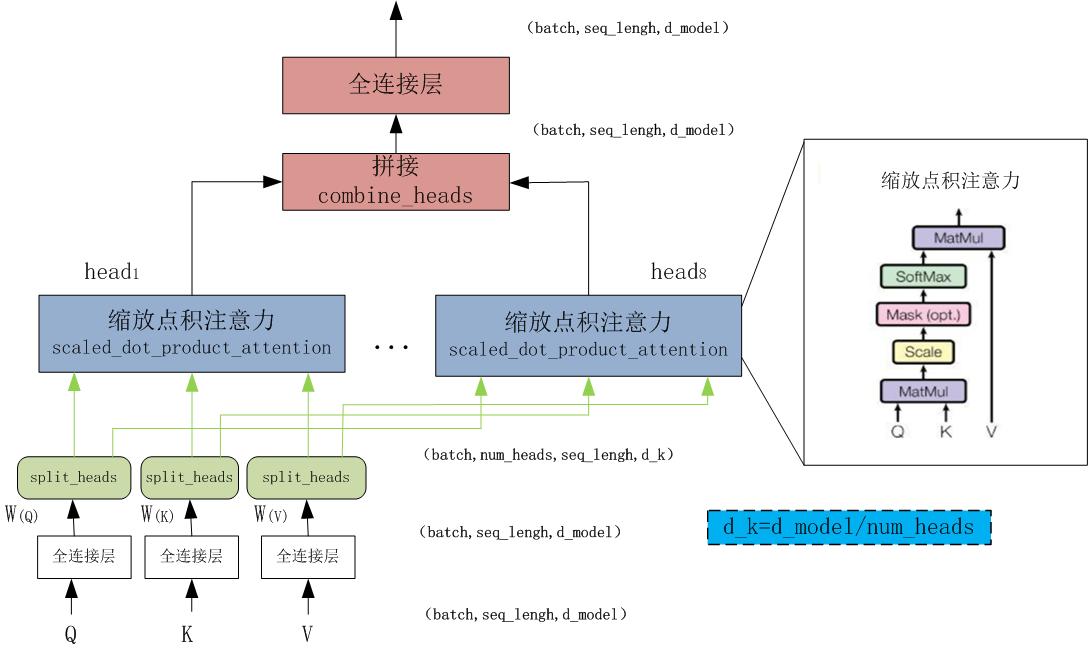

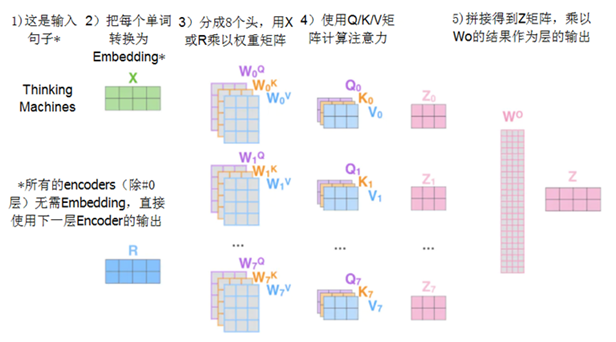

<font color=blue>这里使用继承nn.Module基类来构建神经网络：</font>    
<font color=blue>1.先定义一个类，使之继承nn.Module基类；</font>    
<font color=blue>2.在构造函数（即 def __init__()函数）中定义网络层，张量等</font>    
<font color=blue>3.在forward方法中实现正向传播</font>

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # 确保模型维度d_model能被头数（number of heads）整除，这个整除数为d_k
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # 初始化维度
        self.d_model = d_model # 模型维度
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # 每个头的K,Q,V的维度
        
        # 用于转换输入的线性层
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # 计算注意力得分，transpose为转置函数,把第-2，-1轴互换
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # 如果提供了掩码（mask），则应用它（这对于防止对某些部分（如填充部分）的关注很有用）
        if mask is not None:
            #把矩阵mask中值为0或False的值替换为负无穷大（这里用-le9代替）
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # 利用函数Softmax计算注意力概率分布，按最后一个轴计算（如mxn矩阵，按同行不同列） 
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # 与V相乘以获得最终输出
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # 修改输入尺寸大小，使其具有num_heads，以实现多头注意力
        #x的维度为(batch_size, seq_length, d_model)
        #这里主要把d_model维度拆分为num_headers分配给每个head,每份的维度变为d_k(=d_model/num_heads)
        #同时x的维度由3维变为4维
        #输出维度为(batch_size,num_heads,seq_length, d_k)
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)#交换维度1,2的位置
        
    def combine_heads(self, x):
        # 将多个头组合回原始形状
        #x的维度为(batch_size,num_heads,seq_length,d_k)
        #通过view方法，把num_heads与d_k合并一个，其长度变为d_model
        #输入维度由(batch_size,num_heads,seq_length, d_k) 变为(batch_size,seq_length, d_model)
        batch_size, _, seq_length, d_k = x.size()
        #contiguous()将返回一个内存连续的张量，以便后面的view操作
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # 使用全连接层分拆d_model成num_heads给每个head
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # 计算缩放点积注意力
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # 拼接num_heads个heads，并通过全连接层输出Z
        output = self.W_o(self.combine_heads(attn_output))
        return output

<font color=blue size=3>PyTorch中，contiguous()函数的主要作用是将一个‌Tensor的内存布局转换为连续的，以确保某些操作可以正确执行或提高性能。 当Tensor通过某些操作（如转置或切片）后，其内存布局可能不再连续，这时调用contiguous()函数可以创建一个新的连续的Tensor，它重新排列数据以确保内存布局的连续性。这种连续性对于如view()这样的操作至关重要，因为这些操作要求Tensor的内存是连续存储的。此外，contiguous()函数通过返回一个新的Tensor来实现，原始Tensor不会被改变。这种连续的内存布局可以优化数据访问和处理效率，因为处理器可以按照内存地址的顺序依次读取数据，而不需要在不同的内存位置之间进行跳转</font>

### 2.2 前馈神经网络
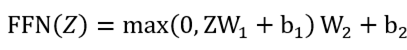

In [3]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

### 2.3 位置编码

位置编码用于在输入序列中注入每个标记（Token）的位置信息。它使用不同频率的正弦和余弦函数来生成位置编码
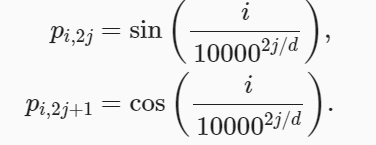

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        #生成一个0矩阵，尺寸大小为(max_seq_length, d_model)
        pe = torch.zeros(max_seq_length, d_model)
        #生成一个由0到max_seq_length（小于这个值）的序列，并在第二个位置增加一个维度
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        #计算公式中括号中指
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        #列索引为偶数，置为sin值，列索引为奇数的置为cos值
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe.unsqueeze(0)增加一个维度，然后注册张量pe，使之变为不参与更新的参数
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

<font color=blue>1.通过register_buffer()登记过的张量：会自动成为模型中的参数，随着模型移动（gpu/cpu）而移动，但是不会随着梯度进行更新</font>  
<font color=blue>2.在PyTorch中，unsqueeze(0)是一个常用的函数，它用于在张量的指定维度上插入一个新的维度，新的维度大小为1。例如，如果你有一个形状为(3,)的张量，使用unsqueeze(1)会使其形状变为(1,3)。</font>

## 3. 构建编码器层

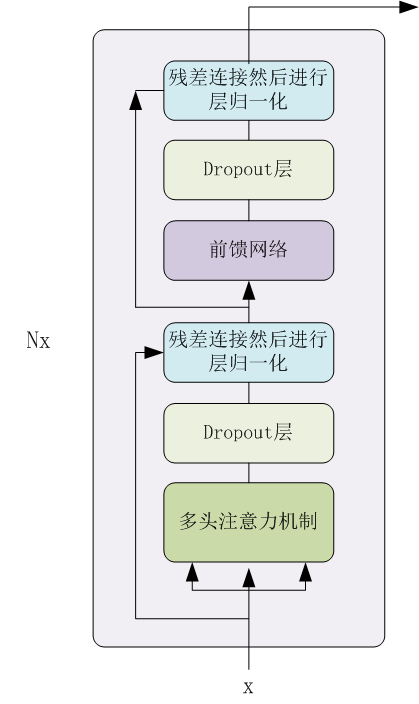

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        #初始化类
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        #先残差连接，然后再进行层归一化
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

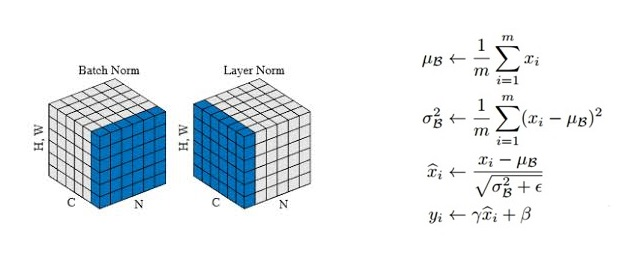
N为batch size，C为channel（通道数），H,W代表每个特征向量的高和宽。
简单的理解就是BatchNorm是对一个batch size样本内的每个特征做归一化，LayerNorm是对每个样本的所有特征做归一化，LayerNorm善于处于输入为不定长的数据。

### 4. 构建解码器层
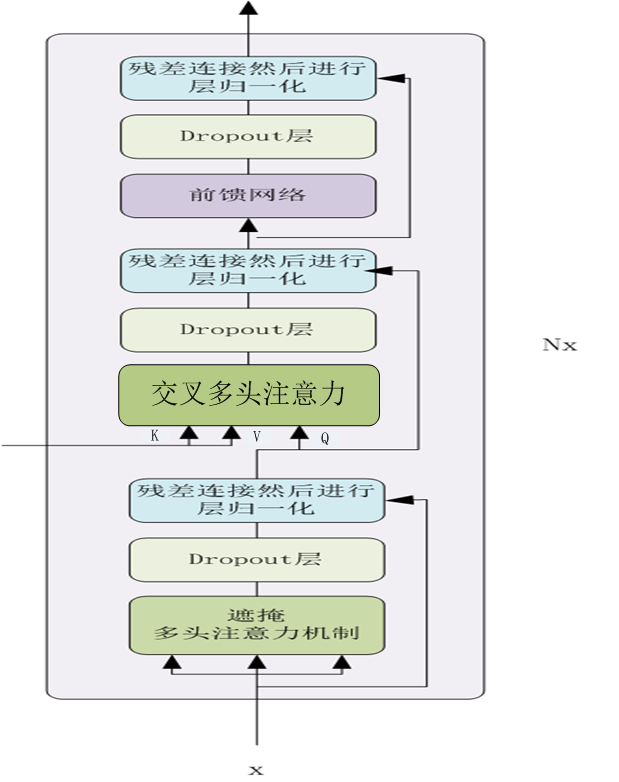

In [6]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        #定义交叉注意力层，该层的输入K,V来自编码器层，Q来自下层的输出
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        #enc_output为编码器层的输出
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

## 5. 结合编码器层和解码器层，创建完整的Transformer网络
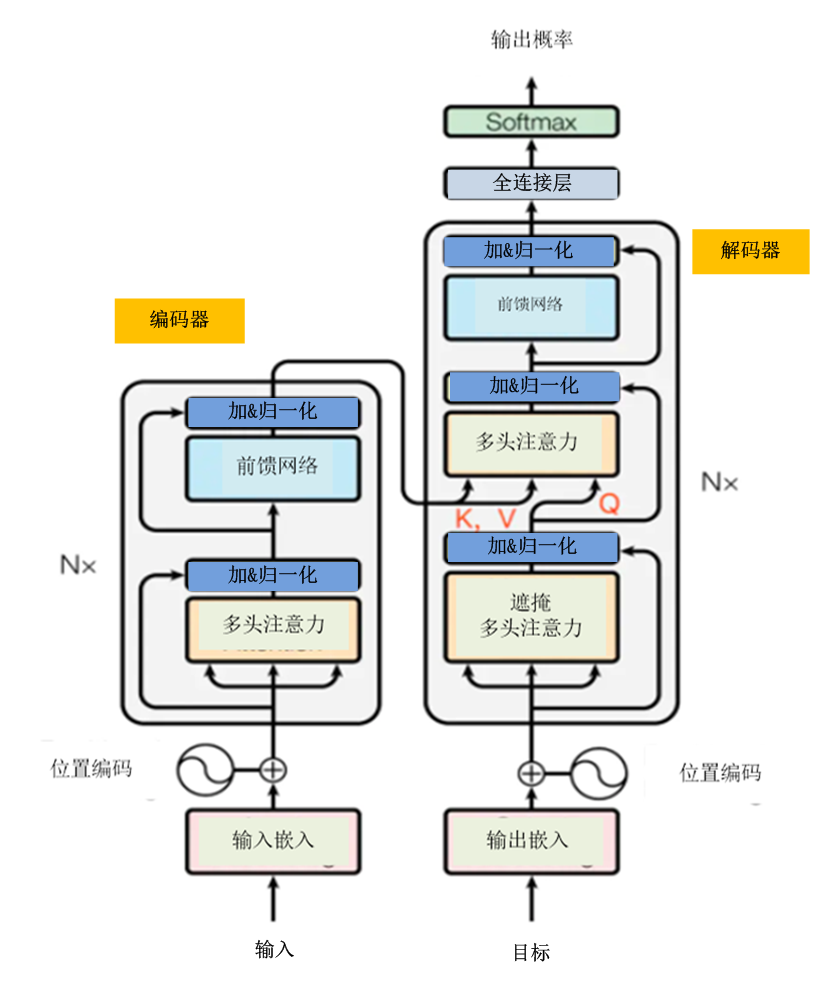

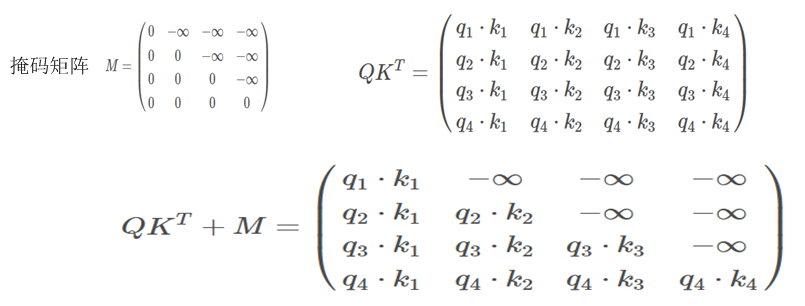

In [7]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        #定义嵌入层
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        #构建编码器和解码器
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        #定义输出层
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        #把src变为逻辑值，如True，并在1,2轴增加维度,src的尺寸由[64, 10]变为[64, 1, 1, 10]
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        #把tgt变为逻辑值，如True，并在1,3轴增加维度,tgt的尺寸由[64, 10]变为[64, 1, 10, 1]
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        #获取tgt尺寸中表示序列长度的值
        seq_length = tgt.size(1)
        #生成一个[1,seq_length,seq_length]上三角矩阵,对角线及以下为True，上三角为False
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        #把参与训练的数据迁移到GPU上
        nopeak_mask=nopeak_mask.to(device)
        #实现逻辑与的计算,使生成数据看不到未来的数据
        tgt_mask = tgt_mask & nopeak_mask        
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

## 6 训练Transformer模型

### 6.1合成数据

In [8]:
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048   #两个全连接层中间层的节点数
dropout = 0.1 #节点被弃用的概率

#判断当前环境是否有GPU，有则用之，否则就是使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_seq_length1=10
src_vocab_size1=10
tgt_vocab_size1=10
batch_size=64
# 生成随机采样样本
src_data1 = torch.randint(1, src_vocab_size1, (batch_size, max_seq_length1))  # (batch_size, seq_length)
tgt_data1=src_data1
#tgt_data1 = torch.randint(1, tgt_vocab_size1, (batch_size, max_seq_length1))  # (batch_size, seq_length)
#把训练数据迁移到GPU
src_data1=src_data1.to(device)
tgt_data1=tgt_data1.to(device)

### 6.2 实例化模型

In [9]:
#实例化Transformer类
transformer1 = Transformer(src_vocab_size1, tgt_vocab_size1, d_model, num_heads, num_layers, d_ff, max_seq_length1, dropout)
#把模型迁移到GPU
transformer1=transformer1.to(device)


### 6.3 利用合成数据训练模型

In [10]:
#定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer1.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

#设置训练模式
transformer1.train()

for epoch in range(100):
    #清除过往梯度
    optimizer.zero_grad()
    #前向传播
    output1 = transformer1(src_data1, tgt_data1)
    #定义损失值
    loss1 = criterion(output1.contiguous().view(-1, tgt_vocab_size1), tgt_data1.contiguous().view(-1))
    #反向传播，计算当前梯度
    loss1.backward()
    #根据梯度更新网络参数
    optimizer.step()
    if (epoch+1)%10 ==0 :
        print(f"Epoch: {epoch+1}, Loss: {loss1.item()}")

Epoch: 10, Loss: 0.02165403589606285
Epoch: 20, Loss: 0.0019632207695394754
Epoch: 30, Loss: 0.0008573558880016208
Epoch: 40, Loss: 0.0004979365621693432
Epoch: 50, Loss: 0.00035779192694462836
Epoch: 60, Loss: 0.0002920790284406394
Epoch: 70, Loss: 0.0002609574585221708
Epoch: 80, Loss: 0.0002357569755986333
Epoch: 90, Loss: 0.0002190632076235488
Epoch: 100, Loss: 0.0001995391648961231
